# Sketchpad

Various experiments with ideology graphs.

In [1]:
# imports and includes
using LightGraphs, MetaGraphs, SNAPDatasets, Random, GraphPlot, Compose, Plots
include("../src/models.jl")   # Graph models
include("../src/dynamics.jl") # Dynamical systems
include("../src/dataviz.jl")  # Plotting for our graphs

drawcolorgraph (generic function with 1 method)

## Simple ideology graphs

Here we do the simple experiments. No quality attribute, 1- and 2-D ideology attributes, various graph generation models. No "media accounts."

### Erdos-Renyi models with a few different parameters. Small models.

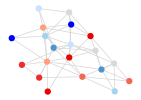

In [2]:
model = ermodel(20, 0.3, IGraph)
assignid!(model)
colornet!(model)
drawcolorgraph(model)

In [ ]:
model = ermodel(50, 0.15, IGraph)
assignid!(model)
colornet!(model)
drawcolorgraph(model)

### Erdos-Renyi model with media accounts added

In [ ]:
model = ermodel(30, 0.2, IGraph)
assignid!(model)
addmedia_rand!(model, 2, 6, 0.5)
colornet!(model)
drawcolorgraph(model)

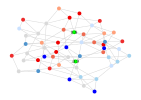

In [3]:
model = wsmodel(50, 4, 0.3, IGraph)
assignid!(model)
addmedia_nearest!(model, 2, 5, [-0.9, 0.9])
colornet!(model)
drawcolorgraph(model)

## Simple dynamical experiments

In a simple ER model all but the most extreme accounts homogenize to 0 ideology. In sufficiently connected graphs all accounts will homogenize.

In [5]:
model = ermodel(20, 0.3, IGraph)
assignid!(model)
ids, steps = fullsim_draw(model, 0.5)

Context(BBox{l,t,r,b,w,h = 0.0w,0.0h, 1.0w,1.0h, 1.0w,1.0h}, UnitBox{Float64,Float64,Float64,Float64}(-1.2, -1.2, 2.4, 2.4, 0.0mm, 0.0mm, 0.0mm, 0.0mm), nothing, nothing, nothing, List([Context(BBox{l,t,r,b,w,h = 0.0w,0.0h, 1.0w,1.0h, 1.0w,1.0h}, nothing, nothing, nothing, nothing, List([]), List([Compose.Form{Compose.LinePrimitive}(Compose.LinePrimitive[Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(-0.6877436343489173cx, 0.19187707140052934cy), (-0.8388485627081169cx, -0.5648890361157772cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(-0.6920047469417351cx, 0.30049020213111544cy), (-0.8004371982129223cx, 0.6840602594017541cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(-0.6635577824753988cx, 0.30100783563372563cy), (-0.5227465780427686cx, 0.878626282274796cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(-0.6347565923478198cx, 0.2835415302922245cy), (-0.16841205810902266cx, 0.69

Compose.Property{Compose.LineWidthPrimitive}(Compose.LineWidthPrimitive[Compose.LineWidthPrimitive(0.6708203932499369mm)]), Compose.Property{Compose.FillPrimitive}(Compose.FillPrimitive[Compose.FillPrimitive(RGBA{Float64}(0.0,0.0,0.0,0.0))]), Compose.Property{Compose.StrokePrimitive}(Compose.StrokePrimitive[Compose.StrokePrimitive(RGBA{Float64}(0.8274509803921568,0.8274509803921568,0.8274509803921568,1.0))])]), 0, false, false, false, false, nothing, nothing, 0.0, Symbol("")), Context(BBox{l,t,r,b,w,h = 0.0w,0.0h, 1.0w,1.0h, 1.0w,1.0h}, nothing, nothing, nothing, nothing, List([]), List([]), List([Compose.Property{Compose.LineWidthPrimitive}(Compose.LineWidthPrimitive[Compose.LineWidthPrimitive(0.6708203932499369mm)]), Compose.Property{Compose.StrokePrimitive}(Compose.StrokePrimitive[Compose.StrokePrimitive(RGBA{Float64}(0.8274509803921568,0.8274509803921568,0.8274509803921568,1.0))])]), 0, false, false, false, false, nothing, nothing, 0.0, Symbol("")), Context(BBox{l,t,r,b,w,h = 0.0w,

Float64},Measures.Length{:cy,Float64}},Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}},Tuple{Measures.Length{:mm,Float64},Measures.Length{:mm,Float64}}}((-0.01655523191097641cx, 0.40656338821488003cy), "", Compose.HCenter(), Compose.VCenter(), Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}}(0.0, (0.5w, 0.5h)), (0.0mm, 0.0mm)), Compose.TextPrimitive{Tuple{Measures.Length{:cx,Float64},Measures.Length{:cy,Float64}},Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}},Tuple{Measures.Length{:mm,Float64},Measures.Length{:mm,Float64}}}((0.4629734045417635cx, 0.4840097820361251cy), "", Compose.HCenter(), Compose.VCenter(), Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}}(0.0, (0.5w, 0.5h)), (0.0mm, 0.0mm)), Compose.TextPrimitive{Tuple{Measures.Length{:cx,Float64},Measures.Length{:cy,Float64}},Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}},Tuple{Measures.Length{:mm,Float64},Me

cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(0.07360062983470089cx, -0.4369747552930156cy), (-0.46061442920148815cx, -0.3316036380119704cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(0.1413010733639773cx, -0.5021961111796415cy), (0.24607586185510882cx, -0.9455965313088825cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(0.10786150419285423cx, -0.39581866787214526cy), (-0.09600104036068749cx, 0.11892508293919923cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(0.17448364129267147cx, -0.4795022767716798cy), (0.661260069166529cx, -0.8147795802760143cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(0.15501919555899854cx, -0.496974399893824cy), (0.2561657454890605cx, -0.6841741127108599cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(0.15594848647224174cx, -0.3991244545055144cy), (0.3350903597167741cx, -0.08212071811574612

, 0.022360679774997897w)], Symbol(""))]), List([Compose.Property{Compose.LineWidthPrimitive}(Compose.LineWidthPrimitive[Compose.LineWidthPrimitive(0.0mm)]), Compose.Property{Compose.StrokePrimitive}(Compose.StrokePrimitive[Compose.StrokePrimitive(RGBA{Float64}(0.0,0.0,0.0,0.0))]), Compose.Property{Compose.FillPrimitive}(Compose.FillPrimitive[Compose.FillPrimitive(RGBA{Float64}(0.9333333333333333,0.4156862745098039,0.3137254901960784,1.0)), Compose.FillPrimitive(RGBA{Float64}(0.6431372549019607,0.8274509803921568,0.9333333333333333,1.0)), Compose.FillPrimitive(RGBA{Float64}(0.8509803921568627,0.8509803921568627,0.8509803921568627,1.0)), Compose.FillPrimitive(RGBA{Float64}(0.0,0.0,1.0,1.0)), Compose.FillPrimitive(RGBA{Float64}(1.0,0.6274509803921569,0.4784313725490196,1.0)), Compose.FillPrimitive(RGBA{Float64}(0.6431372549019607,0.8274509803921568,0.9333333333333333,1.0)), Compose.FillPrimitive(RGBA{Float64}(1.0,0.6274509803921569,0.4784313725490196,1.0)), Compose.FillPrimitive(RGBA{Floa

{Measures.Length{:mm,Float64},Measures.Length{:mm,Float64}}}((0.3328727074426636cx, 0.8355794271221015cy), "", Compose.HCenter(), Compose.VCenter(), Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}}(0.0, (0.5w, 0.5h)), (0.0mm, 0.0mm)), Compose.TextPrimitive{Tuple{Measures.Length{:cx,Float64},Measures.Length{:cy,Float64}},Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}},Tuple{Measures.Length{:mm,Float64},Measures.Length{:mm,Float64}}}((0.4822119222077519cx, 0.2551651249546887cy), "", Compose.HCenter(), Compose.VCenter(), Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}}(0.0, (0.5w, 0.5h)), (0.0mm, 0.0mm)), Compose.TextPrimitive{Tuple{Measures.Length{:cx,Float64},Measures.Length{:cy,Float64}},Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}},Tuple{Measures.Length{:mm,Float64},Measures.Length{:mm,Float64}}}((-0.3229967263420874cx, 0.007667688124882499cy), "", Compose.HCenter(), Compose.VCenter(), 

-0.2230011109585637cx, -0.17562753216112248cy), (-0.4282025123287615cx, -0.31849551892709105cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(-0.12178968454714995cx, -0.13573898610097151cy), (0.3108911742255223cx, -0.07359690872775707cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(-0.41556346766595503cx, -0.8912815574850812cy), (-0.4680668357951241cx, -0.4060142975128613cy)])], Symbol(""))]), List([Compose.Property{Compose.LineWidthPrimitive}(Compose.LineWidthPrimitive[Compose.LineWidthPrimitive(0.6708203932499369mm)]), Compose.Property{Compose.FillPrimitive}(Compose.FillPrimitive[Compose.FillPrimitive(RGBA{Float64}(0.0,0.0,0.0,0.0))]), Compose.Property{Compose.StrokePrimitive}(Compose.StrokePrimitive[Compose.StrokePrimitive(RGBA{Float64}(0.8274509803921568,0.8274509803921568,0.8274509803921568,1.0))])]), 0, false, false, false, false, nothing, nothing, 0.0, Symbol("")), Context(BBox{l,t,r,b,w,h = 0.0w,0.0h, 1.0w,1.0h, 1.0w,1.0h},

cy), "", Compose.HCenter(), Compose.VCenter(), Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}}(0.0, (0.5w, 0.5h)), (0.0mm, 0.0mm)), Compose.TextPrimitive{Tuple{Measures.Length{:cx,Float64},Measures.Length{:cy,Float64}},Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}},Tuple{Measures.Length{:mm,Float64},Measures.Length{:mm,Float64}}}((0.5563071022637118cx, 0.2907018393251235cy), "", Compose.HCenter(), Compose.VCenter(), Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}}(0.0, (0.5w, 0.5h)), (0.0mm, 0.0mm)), Compose.TextPrimitive{Tuple{Measures.Length{:cx,Float64},Measures.Length{:cy,Float64}},Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}},Tuple{Measures.Length{:mm,Float64},Measures.Length{:mm,Float64}}}((-0.34321339112586235cx, 0.7566178136087869cy), "", Compose.HCenter(), Compose.VCenter(), Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}}(0.0, (0.5w, 0.5h)), (0.0mm, 0.

{Tuple{Measure,Measure},Measure}((-0.5004479676699896cx, 0.3112187070824841cy), 0.022360679774997897w), Compose.CirclePrimitive{Tuple{Measure,Measure},Measure}((0.19446902385914466cx, -0.34121336143197434cy), 0.022360679774997897w), Compose.CirclePrimitive{Tuple{Measure,Measure},Measure}((-0.8001247588029481cx, -0.46412565376477877cy), 0.022360679774997897w), Compose.CirclePrimitive{Tuple{Measure,Measure},Measure}((-0.5101138726307377cx, 1.0cy), 0.022360679774997897w), Compose.CirclePrimitive{Tuple{Measure,Measure},Measure}((0.060563954899678585cx, 0.05480627329110277cy), 0.022360679774997897w), Compose.CirclePrimitive{Tuple{Measure,Measure},Measure}((0.5075160208235321cx, -0.41040296778452234cy), 0.022360679774997897w), Compose.CirclePrimitive{Tuple{Measure,Measure},Measure}((1.0cx, 0.20014845915702884cy), 0.022360679774997897w), Compose.CirclePrimitive{Tuple{Measure,Measure},Measure}((0.5972442263495479cx, 0.19222193269578947cy), 0.022360679774997897w), Compose.CirclePrimitive{Tuple{

Length{:w,Float64},Measures.Length{:h,Float64}}}(0.0, (0.5w, 0.5h)), (0.0mm, 0.0mm)), Compose.TextPrimitive{Tuple{Measures.Length{:cx,Float64},Measures.Length{:cy,Float64}},Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}},Tuple{Measures.Length{:mm,Float64},Measures.Length{:mm,Float64}}}((-0.0433416502717322cx, 0.3756295144140023cy), "", Compose.HCenter(), Compose.VCenter(), Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}}(0.0, (0.5w, 0.5h)), (0.0mm, 0.0mm)), Compose.TextPrimitive{Tuple{Measures.Length{:cx,Float64},Measures.Length{:cy,Float64}},Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}},Tuple{Measures.Length{:mm,Float64},Measures.Length{:mm,Float64}}}((-0.2481052023000454cx, 0.3838959892460512cy), "", Compose.HCenter(), Compose.VCenter(), Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}}(0.0, (0.5w, 0.5h)), (0.0mm, 0.0mm)), Compose.TextPrimitive{Tuple{Measures.Length{:cx,Float64},Measure

CirclePrimitive{Tuple{Measure,Measure},Measure}((-0.07875512270450913cx, 1.0cy), 0.022360679774997897w), Compose.CirclePrimitive{Tuple{Measure,Measure},Measure}((-0.3463361352635971cx, -1.0cy), 0.022360679774997897w), Compose.CirclePrimitive{Tuple{Measure,Measure},Measure}((0.3691810086177212cx, 0.37185912355061346cy), 0.022360679774997897w), Compose.CirclePrimitive{Tuple{Measure,Measure},Measure}((-0.1521317882937665cx, 0.5593812494558021cy), 0.022360679774997897w), Compose.CirclePrimitive{Tuple{Measure,Measure},Measure}((-0.39691118962664407cx, 0.72977401841153cy), 0.022360679774997897w), Compose.CirclePrimitive{Tuple{Measure,Measure},Measure}((0.2316407852906197cx, 0.15069519819941468cy), 0.022360679774997897w), Compose.CirclePrimitive{Tuple{Measure,Measure},Measure}((-0.11532770239358048cx, 0.0845868669139982cy), 0.022360679774997897w), Compose.CirclePrimitive{Tuple{Measure,Measure},Measure}((-0.9737348789671977cx, -0.6520799729584817cy), 0.022360679774997897w), Compose.CirclePrimi

Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}}(0.0, (0.5w, 0.5h)), (0.0mm, 0.0mm)), Compose.TextPrimitive{Tuple{Measures.Length{:cx,Float64},Measures.Length{:cy,Float64}},Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}},Tuple{Measures.Length{:mm,Float64},Measures.Length{:mm,Float64}}}((0.2316407852906197cx, 0.15069519819941468cy), "", Compose.HCenter(), Compose.VCenter(), Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}}(0.0, (0.5w, 0.5h)), (0.0mm, 0.0mm)), Compose.TextPrimitive{Tuple{Measures.Length{:cx,Float64},Measures.Length{:cy,Float64}},Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}},Tuple{Measures.Length{:mm,Float64},Measures.Length{:mm,Float64}}}((-0.11532770239358048cx, 0.0845868669139982cy), "", Compose.HCenter(), Compose.VCenter(), Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}}(0.0, (0.5w, 0.5h)), (0.0mm, 0.0mm)), Compose.TextPrimitive{Tuple{Measures.Length{:cx,

Context(BBox{l,t,r,b,w,h = 0.0w,0.0h, 1.0w,1.0h, 1.0w,1.0h}, nothing, nothing, nothing, nothing, List([]), List([Compose.Form{Compose.TextPrimitive{Tuple{Measures.Length{:cx,Float64},Measures.Length{:cy,Float64}},Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}},Tuple{Measures.Length{:mm,Float64},Measures.Length{:mm,Float64}}}}(Compose.TextPrimitive{Tuple{Measures.Length{:cx,Float64},Measures.Length{:cy,Float64}},Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}},Tuple{Measures.Length{:mm,Float64},Measures.Length{:mm,Float64}}}[Compose.TextPrimitive{Tuple{Measures.Length{:cx,Float64},Measures.Length{:cy,Float64}},Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}},Tuple{Measures.Length{:mm,Float64},Measures.Length{:mm,Float64}}}((-0.49089770438761193cx, 0.09242085528532851cy), "", Compose.HCenter(), Compose.VCenter(), Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}}(0.0, (0.5w, 0.5h)), (0.0mm, 0.0

cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(-0.34206919875601804cx, -0.36028781798728066cy), (-0.13396970093601976cx, -0.9473110586298121cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(-0.31128498650757236cx, -0.33364631362533526cy), (0.17852277052720164cx, -0.5915842918186616cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(-0.3294750890097312cx, -0.2612626905696681cy), (-0.10551259509421387cx, 0.07058248449867044cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(-0.3378698729205812cx, -0.2565928138236181cy), (-0.0709296812834895cx, 0.33855735505995216cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(0.4201249630372249cx, 0.01660986292181033cy), (0.6466690990981557cx, -0.10343110495742802cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(0.36572513982937027cx, -0.01289366857532355cy), (0.2893881229903795cx, -0.862240760

1.0,0.6274509803921569,0.4784313725490196,1.0)), Compose.FillPrimitive(RGBA{Float64}(0.6431372549019607,0.8274509803921568,0.9333333333333333,1.0)), Compose.FillPrimitive(RGBA{Float64}(0.6431372549019607,0.8274509803921568,0.9333333333333333,1.0)), Compose.FillPrimitive(RGBA{Float64}(0.8509803921568627,0.8509803921568627,0.8509803921568627,1.0)), Compose.FillPrimitive(RGBA{Float64}(0.6431372549019607,0.8274509803921568,0.9333333333333333,1.0)), Compose.FillPrimitive(RGBA{Float64}(0.8509803921568627,0.8509803921568627,0.8509803921568627,1.0)), Compose.FillPrimitive(RGBA{Float64}(0.8509803921568627,0.8509803921568627,0.8509803921568627,1.0)), Compose.FillPrimitive(RGBA{Float64}(1.0,0.6274509803921569,0.4784313725490196,1.0))])]), 0, false, false, false, false, nothing, nothing, 0.0, Symbol("")), Context(BBox{l,t,r,b,w,h = 0.0w,0.0h, 1.0w,1.0h, 1.0w,1.0h}, nothing, nothing, nothing, nothing, List([]), List([Compose.Form{Compose.TextPrimitive{Tuple{Measures.Length{:cx,Float64},Measures.Len

, nothing, nothing, 0.0, Symbol(""))]), List([]), List([]), 0, false, false, false, false, nothing, nothing, 0.0, Symbol(""))Context(BBox{l,t,r,b,w,h = 0.0w,0.0h, 1.0w,1.0h, 1.0w,1.0h}, UnitBox{Float64,Float64,Float64,Float64}(-1.2, -1.2, 2.4, 2.4, 0.0mm, 0.0mm, 0.0mm, 0.0mm), nothing, nothing, nothing, List([Context(BBox{l,t,r,b,w,h = 0.0w,0.0h, 1.0w,1.0h, 1.0w,1.0h}, nothing, nothing, nothing, nothing, List([]), List([Compose.Form{Compose.LinePrimitive}(Compose.LinePrimitive[Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(-0.10812433571817857cx, 0.5277929431682908cy), (-0.6263608895840832cx, 0.32366991523364796cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(-0.021477586771511452cx, 0.5921597486934793cy), (0.2657936037339369cx, 0.956119864917788cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(-0.0006720643735291451cx, 0.5554509230670986cy), (0.35757622384372384cx, 0.6017914394846636cy)]), Compose.LinePrimit

cy), 0.022360679774997897w), Compose.CirclePrimitive{Tuple{Measure,Measure},Measure}((0.5792181493711939cx, 0.0929774635004803cy), 0.022360679774997897w), Compose.CirclePrimitive{Tuple{Measure,Measure},Measure}((-0.2096384758587666cx, -0.7319172697234255cy), 0.022360679774997897w), Compose.CirclePrimitive{Tuple{Measure,Measure},Measure}((0.41301603193041103cx, 0.608962748940495cy), 0.022360679774997897w), Compose.CirclePrimitive{Tuple{Measure,Measure},Measure}((-1.0cx, 0.2730826750697348cy), 0.022360679774997897w), Compose.CirclePrimitive{Tuple{Measure,Measure},Measure}((0.33053828026401333cx, 0.13478236384985554cy), 0.022360679774997897w), Compose.CirclePrimitive{Tuple{Measure,Measure},Measure}((0.1739909080434776cx, 0.33853296211734274cy), 0.022360679774997897w), Compose.CirclePrimitive{Tuple{Measure,Measure},Measure}((0.4080287140513439cx, -0.11846536595138601cy), 0.022360679774997897w), Compose.CirclePrimitive{Tuple{Measure,Measure},Measure}((-0.004785323396964136cx, 0.105573769567

(0.5w, 0.5h)), (0.0mm, 0.0mm)), Compose.TextPrimitive{Tuple{Measures.Length{:cx,Float64},Measures.Length{:cy,Float64}},Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}},Tuple{Measures.Length{:mm,Float64},Measures.Length{:mm,Float64}}}((0.4080287140513439cx, -0.11846536595138601cy), "", Compose.HCenter(), Compose.VCenter(), Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}}(0.0, (0.5w, 0.5h)), (0.0mm, 0.0mm)), Compose.TextPrimitive{Tuple{Measures.Length{:cx,Float64},Measures.Length{:cy,Float64}},Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}},Tuple{Measures.Length{:mm,Float64},Measures.Length{:mm,Float64}}}((-0.004785323396964136cx, 0.10557376956774633cy), "", Compose.HCenter(), Compose.VCenter(), Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}}(0.0, (0.5w, 0.5h)), (0.0mm, 0.0mm)), Compose.TextPrimitive{Tuple{Measures.Length{:cx,Float64},Measures.Length{:cy,Float64}},Rotation{Tuple{Measures.Len

cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(-0.05630123595073567cx, -0.27376325307846866cy), (-0.3481620792421747cx, 0.2915611401951001cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(0.01896309256048962cx, -0.29768945296305793cy), (0.4052381742356969cx, -0.09726225132396206cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(-0.07624903838563404cx, 0.04699660338980498cy), (-0.3340569493433099cx, 0.30192759899959826cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(0.018689841948132044cx, -0.0012059271762351696cy), (0.3996687523120209cx, -0.062619461838013cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(-0.5581034873992434cx, 0.9465222399870259cy), (-0.39008937178884595cx, 0.3947114216348062cy)])], Symbol(""))]), List([Compose.Property{Compose.LineWidthPrimitive}(Compose.LineWidthPrimitive[Compose.LineWidthPrimitive(0.6708203932499369mm)]), Compose.

},Tuple{Measures.Length{:mm,Float64},Measures.Length{:mm,Float64}}}((0.33844003020917457cx, 0.8290873772804972cy), "", Compose.HCenter(), Compose.VCenter(), Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}}(0.0, (0.5w, 0.5h)), (0.0mm, 0.0mm)), Compose.TextPrimitive{Tuple{Measures.Length{:cx,Float64},Measures.Length{:cy,Float64}},Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}},Tuple{Measures.Length{:mm,Float64},Measures.Length{:mm,Float64}}}((1.0cx, -0.006371414837633482cy), "", Compose.HCenter(), Compose.VCenter(), Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}}(0.0, (0.5w, 0.5h)), (0.0mm, 0.0mm)), Compose.TextPrimitive{Tuple{Measures.Length{:cx,Float64},Measures.Length{:cy,Float64}},Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}},Tuple{Measures.Length{:mm,Float64},Measures.Length{:mm,Float64}}}((0.592614030168491cx, 0.2340920650835665cy), "", Compose.HCenter(), Compose.VCenter(), Rotation

)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(0.33239119645844994cx, -0.24337739752484214cy), (-0.3273885083925352cx, -0.3537281654101766cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(0.3327753603899027cx, -0.2228750045078532cy), (-0.10631883827735691cx, -0.1324066713253344cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(0.3664488755360603cx, -0.182380124872139cy), (0.2545386936261719cx, 0.09251179466367981cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(0.8452551106430826cx, -0.11075592246575569cy), (0.07119380781115939cx, 0.03893064105283072cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(0.8803347966487585cx, -0.17364520842302633cy), (0.7209807098853895cx, -0.5942592725999648cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(-0.34477039572919715cx, -0.32172317041643234cy), (-0.19882446041847573cx, -0.1623526472756163

BBox{l,t,r,b,w,h = 0.0w,0.0h, 1.0w,1.0h, 1.0w,1.0h}, nothing, nothing, nothing, nothing, List([]), List([Compose.Form{Compose.TextPrimitive{Tuple{Measures.Length{:cx,Float64},Measures.Length{:cy,Float64}},Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}},Tuple{Measures.Length{:mm,Float64},Measures.Length{:mm,Float64}}}}(Compose.TextPrimitive{Tuple{Measures.Length{:cx,Float64},Measures.Length{:cy,Float64}},Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}},Tuple{Measures.Length{:mm,Float64},Measures.Length{:mm,Float64}}}[Compose.TextPrimitive{Tuple{Measures.Length{:cx,Float64},Measures.Length{:cy,Float64}},Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}},Tuple{Measures.Length{:mm,Float64},Measures.Length{:mm,Float64}}}((-0.5103886040099839cx, -0.21606429707071328cy), "", Compose.HCenter(), Compose.VCenter(), Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}}(0.0, (0.5w, 0.5h)), (0.0mm, 0.0mm)), Co

mm,Float64},Measures.Length{:mm,Float64}}}((0.12389412180612869cx, -0.33719486262642717cy), "", Compose.HCenter(), Compose.VCenter(), Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}}(0.0, (0.5w, 0.5h)), (0.0mm, 0.0mm)), Compose.TextPrimitive{Tuple{Measures.Length{:cx,Float64},Measures.Length{:cy,Float64}},Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}},Tuple{Measures.Length{:mm,Float64},Measures.Length{:mm,Float64}}}((0.0715435346128841cx, 0.5092582826954741cy), "", Compose.HCenter(), Compose.VCenter(), Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}}(0.0, (0.5w, 0.5h)), (0.0mm, 0.0mm))], Symbol(""))]), List([Compose.Property{Compose.FontSizePrimitive}(Compose.FontSizePrimitive[Compose.FontSizePrimitive(4.0mm)]), Compose.Property{Compose.StrokePrimitive}(Compose.StrokePrimitive[Compose.StrokePrimitive(RGBA{Float64}(0.0,0.0,0.0,0.0))]), Compose.Property{Compose.FillPrimitive}(Compose.FillPrimitive[Compose.FillPrimi

""))]), List([Compose.Property{Compose.LineWidthPrimitive}(Compose.LineWidthPrimitive[Compose.LineWidthPrimitive(0.6708203932499369mm)]), Compose.Property{Compose.FillPrimitive}(Compose.FillPrimitive[Compose.FillPrimitive(RGBA{Float64}(0.0,0.0,0.0,0.0))]), Compose.Property{Compose.StrokePrimitive}(Compose.StrokePrimitive[Compose.StrokePrimitive(RGBA{Float64}(0.8274509803921568,0.8274509803921568,0.8274509803921568,1.0))])]), 0, false, false, false, false, nothing, nothing, 0.0, Symbol("")), Context(BBox{l,t,r,b,w,h = 0.0w,0.0h, 1.0w,1.0h, 1.0w,1.0h}, nothing, nothing, nothing, nothing, List([]), List([]), List([Compose.Property{Compose.LineWidthPrimitive}(Compose.LineWidthPrimitive[Compose.LineWidthPrimitive(0.6708203932499369mm)]), Compose.Property{Compose.StrokePrimitive}(Compose.StrokePrimitive[Compose.StrokePrimitive(RGBA{Float64}(0.8274509803921568,0.8274509803921568,0.8274509803921568,1.0))])]), 0, false, false, false, false, nothing, nothing, 0.0, Symbol("")), Context(BBox{l,t,r

Length{:mm,Float64}}}((-0.6531978763689805cx, 0.63895028636254cy), "", Compose.HCenter(), Compose.VCenter(), Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}}(0.0, (0.5w, 0.5h)), (0.0mm, 0.0mm)), Compose.TextPrimitive{Tuple{Measures.Length{:cx,Float64},Measures.Length{:cy,Float64}},Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}},Tuple{Measures.Length{:mm,Float64},Measures.Length{:mm,Float64}}}((-0.5186489612510683cx, -0.07500219141309028cy), "", Compose.HCenter(), Compose.VCenter(), Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}}(0.0, (0.5w, 0.5h)), (0.0mm, 0.0mm)), Compose.TextPrimitive{Tuple{Measures.Length{:cx,Float64},Measures.Length{:cy,Float64}},Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}},Tuple{Measures.Length{:mm,Float64},Measures.Length{:mm,Float64}}}((0.1970756095962225cx, 0.8122280795046779cy), "", Compose.HCenter(), Compose.VCenter(), Rotation{Tuple{Measures.Length{:w,Float6

Compose.StrokePrimitive(RGBA{Float64}(0.8274509803921568,0.8274509803921568,0.8274509803921568,1.0))])]), 0, false, false, false, false, nothing, nothing, 0.0, Symbol("")), Context(BBox{l,t,r,b,w,h = 0.0w,0.0h, 1.0w,1.0h, 1.0w,1.0h}, nothing, nothing, nothing, nothing, List([]), List([]), List([Compose.Property{Compose.LineWidthPrimitive}(Compose.LineWidthPrimitive[Compose.LineWidthPrimitive(0.6708203932499369mm)]), Compose.Property{Compose.StrokePrimitive}(Compose.StrokePrimitive[Compose.StrokePrimitive(RGBA{Float64}(0.8274509803921568,0.8274509803921568,0.8274509803921568,1.0))])]), 0, false, false, false, false, nothing, nothing, 0.0, Symbol("")), Context(BBox{l,t,r,b,w,h = 0.0w,0.0h, 1.0w,1.0h, 1.0w,1.0h}, nothing, nothing, nothing, nothing, List([]), List([]), List([Compose.Property{Compose.FontSizePrimitive}(Compose.FontSizePrimitive[Compose.FontSizePrimitive(4.0mm)]), Compose.Property{Compose.StrokePrimitive}(Compose.StrokePrimitive[Compose.StrokePrimitive(RGBA{Float64}(0.0,0.0,

,Float64}},Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}},Tuple{Measures.Length{:mm,Float64},Measures.Length{:mm,Float64}}}((-0.2254145706168874cx, 0.5148808585581539cy), "", Compose.HCenter(), Compose.VCenter(), Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}}(0.0, (0.5w, 0.5h)), (0.0mm, 0.0mm)), Compose.TextPrimitive{Tuple{Measures.Length{:cx,Float64},Measures.Length{:cy,Float64}},Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}},Tuple{Measures.Length{:mm,Float64},Measures.Length{:mm,Float64}}}((-0.008800020177056389cx, -0.8613401292313757cy), "", Compose.HCenter(), Compose.VCenter(), Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}}(0.0, (0.5w, 0.5h)), (0.0mm, 0.0mm)), Compose.TextPrimitive{Tuple{Measures.Length{:cx,Float64},Measures.Length{:cy,Float64}},Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}},Tuple{Measures.Length{:mm,Float64},Measures.Length{:mm,Float64}

0.9726621202153269cx, -0.41196891211788994cy), (0.8435529059524769cx, -0.642253825979377cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(0.9441072093698196cx, -0.3642058344524178cy), (0.24302856662128378cx, -0.37672371854830905cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(0.11231782019688866cx, -0.5946402111244934cy), (-0.41136062494342934cx, -0.7131754119509488cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(0.198610898644616cx, -0.6282949280132523cy), (0.4235871898433965cx, -0.9540040719933672cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(0.12775549350753357cx, -0.5423317332175749cy), (-0.21295904710463098cx, -0.1939239942259025cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(0.22197462261577688cx, -0.5915293902099821cy), (0.7610806458167592cx, -0.6817844891780767cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(0.

, 0.5897220428883605cy), 0.022360679774997897w), Compose.CirclePrimitive{Tuple{Measure,Measure},Measure}((0.26830893817314716cx, 0.1643772919403752cy), 0.022360679774997897w), Compose.CirclePrimitive{Tuple{Measure,Measure},Measure}((-0.39689950922006656cx, -0.3656536073236687cy), 0.022360679774997897w)], Symbol(""))]), List([Compose.Property{Compose.LineWidthPrimitive}(Compose.LineWidthPrimitive[Compose.LineWidthPrimitive(0.0mm)]), Compose.Property{Compose.StrokePrimitive}(Compose.StrokePrimitive[Compose.StrokePrimitive(RGBA{Float64}(0.0,0.0,0.0,0.0))]), Compose.Property{Compose.FillPrimitive}(Compose.FillPrimitive[Compose.FillPrimitive(RGBA{Float64}(0.8509803921568627,0.8509803921568627,0.8509803921568627,1.0)), Compose.FillPrimitive(RGBA{Float64}(0.6431372549019607,0.8274509803921568,0.9333333333333333,1.0)), Compose.FillPrimitive(RGBA{Float64}(0.8509803921568627,0.8509803921568627,0.8509803921568627,1.0)), Compose.FillPrimitive(RGBA{Float64}(0.6431372549019607,0.8274509803921568,0.9

Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}}(0.0, (0.5w, 0.5h)), (0.0mm, 0.0mm)), Compose.TextPrimitive{Tuple{Measures.Length{:cx,Float64},Measures.Length{:cy,Float64}},Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}},Tuple{Measures.Length{:mm,Float64},Measures.Length{:mm,Float64}}}((-0.04499505156756978cx, 0.5897220428883605cy), "", Compose.HCenter(), Compose.VCenter(), Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}}(0.0, (0.5w, 0.5h)), (0.0mm, 0.0mm)), Compose.TextPrimitive{Tuple{Measures.Length{:cx,Float64},Measures.Length{:cy,Float64}},Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}},Tuple{Measures.Length{:mm,Float64},Measures.Length{:mm,Float64}}}((0.26830893817314716cx, 0.1643772919403752cy), "", Compose.HCenter(), Compose.VCenter(), Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}}(0.0, (0.5w, 0.5h)), (0.0mm, 0.0mm)), Compose.TextPrimitive{Tuple{Measures.Length{:cx,

 0.011773017154928844cy), "", Compose.HCenter(), Compose.VCenter(), Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}}(0.0, (0.5w, 0.5h)), (0.0mm, 0.0mm)), Compose.TextPrimitive{Tuple{Measures.Length{:cx,Float64},Measures.Length{:cy,Float64}},Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}},Tuple{Measures.Length{:mm,Float64},Measures.Length{:mm,Float64}}}((0.08121099705942347cx, -0.5794713166693571cy), "", Compose.HCenter(), Compose.VCenter(), Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}}(0.0, (0.5w, 0.5h)), (0.0mm, 0.0mm)), Compose.TextPrimitive{Tuple{Measures.Length{:cx,Float64},Measures.Length{:cy,Float64}},Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}},Tuple{Measures.Length{:mm,Float64},Measures.Length{:mm,Float64}}}((0.7582216580239778cx, 0.6712699187351963cy), "", Compose.HCenter(), Compose.VCenter(), Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}}(0.0, (0.5

)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(0.1787021920383746cx, 0.5313191787555124cy), (0.29250099248899375cx, -0.33349028795053615cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(0.14406687348488428cx, 0.635501733753931cy), (-0.007118560020735243cx, 0.905107020629827cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(0.11948150991682895cx, 0.5660421216346394cy), (-0.32509845870730214cx, 0.3888098486445939cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(0.2047503169692518cx, 0.5418726094861556cy), (0.3616956562931627cx, 0.3306564633407cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(-0.7999278295800965cx, 0.380599597779874cy), (-0.9617254647549743cx, 0.5528356767628914cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(-0.7458631626711958cx, 0.39348105461710225cy), (-0.5830619248494587cx, 0.9463747098652372cy)]), Compose.

), "", Compose.HCenter(), Compose.VCenter(), Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}}(0.0, (0.5w, 0.5h)), (0.0mm, 0.0mm)), Compose.TextPrimitive{Tuple{Measures.Length{:cx,Float64},Measures.Length{:cy,Float64}},Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}},Tuple{Measures.Length{:mm,Float64},Measures.Length{:mm,Float64}}}((-0.7616532943350708cx, 0.33985576448233945cy), "", Compose.HCenter(), Compose.VCenter(), Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}}(0.0, (0.5w, 0.5h)), (0.0mm, 0.0mm)), Compose.TextPrimitive{Tuple{Measures.Length{:cx,Float64},Measures.Length{:cy,Float64}},Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}},Tuple{Measures.Length{:mm,Float64},Measures.Length{:mm,Float64}}}((-0.24288918736088494cx, -1.0cy), "", Compose.HCenter(), Compose.VCenter(), Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}}(0.0, (0.5w, 0.5h)), (0.0mm, 0.0mm)), Compose

), (-0.09690697574551241cx, 0.10371867393095935cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(0.6107553956053101cx, -0.1436439088998266cy), (0.5342317798793369cx, -0.3837733554501481cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(-0.6976883032294701cx, 0.24639121637285624cy), (-0.946428605970369cx, 0.17223060052765402cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(-0.6287077117550199cx, 0.2086272562347614cy), (-0.5003782237635792cx, -0.23889196878804872cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(-0.5904608576826771cx, 0.24667796230862cy), (-0.20456114386558463cx, 0.13386782341202602cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(0.24462070056592317cx, 0.9812546337088892cy), (0.49519144596773285cx, 0.8920676448388896cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(0.20497456100398212cx, 0.9456354247351944cy), (0

w), Compose.CirclePrimitive{Tuple{Measure,Measure},Measure}((0.3927724892540667cx, 0.1614279654693842cy), 0.022360679774997897w), Compose.CirclePrimitive{Tuple{Measure,Measure},Measure}((0.3482777643982966cx, 0.5067049621726851cy), 0.022360679774997897w), Compose.CirclePrimitive{Tuple{Measure,Measure},Measure}((0.719613411981981cx, 0.45476008813001667cy), 0.022360679774997897w), Compose.CirclePrimitive{Tuple{Measure,Measure},Measure}((0.13671743928114033cx, 0.18961211062451744cy), 0.022360679774997897w), Compose.CirclePrimitive{Tuple{Measure,Measure},Measure}((0.10128218597265515cx, -0.016673446022760552cy), 0.022360679774997897w), Compose.CirclePrimitive{Tuple{Measure,Measure},Measure}((-0.48496902631876004cx, -0.2926279589073959cy), 0.022360679774997897w), Compose.CirclePrimitive{Tuple{Measure,Measure},Measure}((-0.15090509234842264cx, 0.11818253936653744cy), 0.022360679774997897w), Compose.CirclePrimitive{Tuple{Measure,Measure},Measure}((0.5172582552569913cx, -0.43703590760355726cy)

(-0.33251522683363116cx, 0.293541752809915cy), (0.13870068947138353cx, 0.705489553545603cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(-0.427800496503139cx, 0.2395763077702962cy), (-0.9468012479747566cx, 0.07204398330601905cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(-0.4074771305752002cx, 0.21153582087066244cy), (-0.6215168389618864cx, -0.08282915494939666cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(-0.3385840960191085cx, 0.21399680299694776cy), (0.04817906139940307cx, -0.24508031164316232cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(-0.32144590867620604cx, 0.23944392092496378cy), (0.016070841892270912cx, 0.12956567901920116cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(-0.32021906106563097cx, 0.24380565389732461cy), (0.2834418578722691cx, 0.10013415798635725cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}

List([Compose.Form{Compose.CirclePrimitive{Tuple{Measure,Measure},Measure}}(Compose.CirclePrimitive{Tuple{Measure,Measure},Measure}[Compose.CirclePrimitive{Tuple{Measure,Measure},Measure}((-0.3746017444778956cx, 0.2567487503151604cy), 0.022360679774997897w), Compose.CirclePrimitive{Tuple{Measure,Measure},Measure}((0.7187213423547083cx, -0.15026921498254886cy), 0.022360679774997897w), Compose.CirclePrimitive{Tuple{Measure,Measure},Measure}((0.180787207115648cx, 0.7422825560403576cy), 0.022360679774997897w), Compose.CirclePrimitive{Tuple{Measure,Measure},Measure}((-1.0cx, 0.05487154076115486cy), 0.022360679774997897w), Compose.CirclePrimitive{Tuple{Measure,Measure},Measure}((0.2703182094788068cx, -0.1370544375034819cy), 0.022360679774997897w), Compose.CirclePrimitive{Tuple{Measure,Measure},Measure}((0.9886679258885764cx, -0.3853354041375434cy), 0.022360679774997897w), Compose.CirclePrimitive{Tuple{Measure,Measure},Measure}((0.702721972733257cx, -1.0cy), 0.022360679774997897w), Compose.Ci

Length{:mm,Float64}}}((0.8834870724402668cx, 0.626776079419018cy), "", Compose.HCenter(), Compose.VCenter(), Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}}(0.0, (0.5w, 0.5h)), (0.0mm, 0.0mm)), Compose.TextPrimitive{Tuple{Measures.Length{:cx,Float64},Measures.Length{:cy,Float64}},Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}},Tuple{Measures.Length{:mm,Float64},Measures.Length{:mm,Float64}}}((0.31900956208803377cx, 0.35727155529674226cy), "", Compose.HCenter(), Compose.VCenter(), Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}}(0.0, (0.5w, 0.5h)), (0.0mm, 0.0mm)), Compose.TextPrimitive{Tuple{Measures.Length{:cx,Float64},Measures.Length{:cy,Float64}},Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}},Tuple{Measures.Length{:mm,Float64},Measures.Length{:mm,Float64}}}((0.4524391931165572cx, -0.42091268462244147cy), "", Compose.HCenter(), Compose.VCenter(), Rotation{Tuple{Measures.Length{:w,Float

cx, 0.0969959082838232cy), (-0.12419691944720854cx, 0.27223763565905523cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(-0.2442857362800914cx, -0.002530657604007336cy), (-0.49005713382398575cx, -0.40220959480772783cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(-0.47738947474516724cx, 0.6574252008861252cy), (-0.14517829565033846cx, 0.36133948021716694cy)])], Symbol(""))]), List([Compose.Property{Compose.LineWidthPrimitive}(Compose.LineWidthPrimitive[Compose.LineWidthPrimitive(0.6708203932499369mm)]), Compose.Property{Compose.FillPrimitive}(Compose.FillPrimitive[Compose.FillPrimitive(RGBA{Float64}(0.0,0.0,0.0,0.0))]), Compose.Property{Compose.StrokePrimitive}(Compose.StrokePrimitive[Compose.StrokePrimitive(RGBA{Float64}(0.8274509803921568,0.8274509803921568,0.8274509803921568,1.0))])]), 0, false, false, false, false, nothing, nothing, 0.0, Symbol("")), Context(BBox{l,t,r,b,w,h = 0.0w,0.0h, 1.0w,1.0h, 1.0w,1.0h}, nothing, nothing, 

(-0.5191218053878706cx, 0.6946194555382632cy), "", Compose.HCenter(), Compose.VCenter(), Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}}(0.0, (0.5w, 0.5h)), (0.0mm, 0.0mm)), Compose.TextPrimitive{Tuple{Measures.Length{:cx,Float64},Measures.Length{:cy,Float64}},Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}},Tuple{Measures.Length{:mm,Float64},Measures.Length{:mm,Float64}}}((-0.10344596500763514cx, 0.324145225565029cy), "", Compose.HCenter(), Compose.VCenter(), Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}}(0.0, (0.5w, 0.5h)), (0.0mm, 0.0mm)), Compose.TextPrimitive{Tuple{Measures.Length{:cx,Float64},Measures.Length{:cy,Float64}},Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}},Tuple{Measures.Length{:mm,Float64},Measures.Length{:mm,Float64}}}((-0.5193390928848025cx, -0.4498285707895846cy), "", Compose.HCenter(), Compose.VCenter(), Rotation{Tuple{Measures.Length{:w,Float64},Measures.Length{:

, -0.2887212225997825cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(0.23249988495269433cx, -0.03863454156534132cy), (0.3598531538152189cx, 0.3943615699323054cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(0.6339943403573267cx, -0.6404324185616316cy), (0.24081978666710652cx, -0.37563344424322354cy)])], Symbol(""))]), List([Compose.Property{Compose.LineWidthPrimitive}(Compose.LineWidthPrimitive[Compose.LineWidthPrimitive(0.6708203932499369mm)]), Compose.Property{Compose.FillPrimitive}(Compose.FillPrimitive[Compose.FillPrimitive(RGBA{Float64}(0.0,0.0,0.0,0.0))]), Compose.Property{Compose.StrokePrimitive}(Compose.StrokePrimitive[Compose.StrokePrimitive(RGBA{Float64}(0.8274509803921568,0.8274509803921568,0.8274509803921568,1.0))])]), 0, false, false, false, false, nothing, nothing, 0.0, Symbol("")), Context(BBox{l,t,r,b,w,h = 0.0w,0.0h, 1.0w,1.0h, 1.0w,1.0h}, nothing, nothing, nothing, nothing, List([]), List([]), List([Compose.Prop

.Form{Compose.LinePrimitive}(Compose.LinePrimitive[Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(-0.404348186749732cx, -0.3173968257997844cy), (-0.7359774561872326cx, 0.3693761635091691cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(-0.38046771360967374cx, -0.42363685395516326cy), (-0.38399513028149074cx, -0.884653262195468cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(-0.354703791280183cx, -0.417567268498273cy), (-0.08390321513719139cx, -0.9501695222959495cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(-0.32759578561131386cx, -0.38709148884938266cy), (0.18982576955383942cx, -0.5780474982153817cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(-0.34925886922996774cx, -0.321072865060984cy), (-0.13363282637819415cx, 0.0058143308389369056cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(-0.35719604130230326cx, -0.3167156820896

, 0.0, Symbol("")), Context(BBox{l,t,r,b,w,h = 0.0w,0.0h, 1.0w,1.0h, 1.0w,1.0h}, nothing, nothing, nothing, nothing, List([]), List([Compose.Form{Compose.CirclePrimitive{Tuple{Measure,Measure},Measure}}(Compose.CirclePrimitive{Tuple{Measure,Measure},Measure}[Compose.CirclePrimitive{Tuple{Measure,Measure},Measure}((-0.3800400003846669cx, -0.3677367907942226cy), 0.022360679774997897w), Compose.CirclePrimitive{Tuple{Measure,Measure},Measure}((0.39213855471195425cx, 0.08905925896357014cy), 0.022360679774997897w), Compose.CirclePrimitive{Tuple{Measure,Measure},Measure}((-0.7602856425522978cx, 0.4197161285036073cy), 0.022360679774997897w), Compose.CirclePrimitive{Tuple{Measure,Measure},Measure}((-0.3844228435064976cx, -0.9405533253564087cy), 0.022360679774997897w), Compose.CirclePrimitive{Tuple{Measure,Measure},Measure}((0.2556572570448514cx, -0.22097091999199037cy), 0.022360679774997897w), Compose.CirclePrimitive{Tuple{Measure,Measure},Measure}((0.7095986380976698cx, -0.0493451466867314cy),

cx, 0.9513904534793445cy), (-0.07185245305519988cx, 0.4835595813878732cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(-0.39723947092413514cx, 0.011825203567251003cy), (0.2744080668653458cx, -0.0332547355407303cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(-0.5055632071812044cx, 0.03464123747955055cy), (-0.9474524716290075cx, 0.19502743587484614cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(-0.461755596046941cx, -0.03964543804375041cy), (-0.5437035830845734cx, -0.5573502228778081cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(-0.4776077817442031cx, 0.06577069316246983cy), (-0.745143876938441cx, 0.6119140722209754cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(-0.50333038308818cx, 0.0399292456377454cy), (-0.6593461155395849cx, 0.11546601627803471cy)]), Compose.LinePrimitive{Tuple{Measure,Measure}}(Tuple{Measure,Measure}[(-0.40217578945726407cx

Excessive output truncated after 524289 bytes.

), Compose.CirclePrimitive{Tuple{Measure,Measure},Measure}((0.3659653324838592cx, 0.20942864850925624cy), 0.022360679774997897w)], Symbol(""))]), List([Compose.Property{Compose.LineWidthPrimitive}(Compose.LineWidthPrimitive[Compose.LineWidthPrimitive(0.0mm)]), Compose.Property{Compose.StrokePrimitive}(Compose.StrokePrimitive[Compose.StrokePrimitive(RGBA{Float64}(0.0,0.0,0.0,0.0))]), Compose.Property{Compose.FillPrimitive}(Compose.FillPrimitive[Compose.FillPrimitive(RGBA{Float64}(0.8509803921568627,0.8509803921568627,0.8509803921568627,1.0)), Compose.FillPrimitive(RGBA{Float64}(0.6431372549019607,0.8274509803921568,0.9333333333333333,1.0)), Compose.FillPrimitive(RGBA{Float64}(0.8509803921568627,0.8509803921568627,0.8509803921568627,1.0)), Compose.FillPrimitive(RGBA{Float64}(0.6431372549019607,0.8274509803921568,0.9333333333333333,1.0)), Compose.FillPrimitive(RGBA{Float64}(0.8509803921568627,0.8509803921568627,0.8509803921568627,1.0)), Compose.FillPrimitive(RGBA{Float64}(0.64313725490196

([0.7 0.6499999999999999 … 0.18833377564469153 0.1883601874606398; -0.4 -0.5666666666666665 … -0.5359603347590092 -0.5359841562839535; … ; 0.2 0.15 … 0.1883867492826242 0.18840237747728983; 0.3 0.325 … 0.18872150084800463 0.18866898658677947], 30)

25

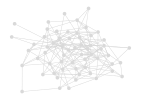

In [4]:
model = ermodel(60, 0.1, IGraph)
assignid!(model)
ids, steps = fullsim!(model, 0.9)
print(steps)
colornet!(model)
drawcolorgraph(model)

In the presence of a media account, most accounts will become "entrained" to the media account. A handful of accounts may retain different ideology.

In [ ]:
model = ermodel(60, 0.1, IGraph)
assignid!(model)
addmedia_nearest!(model, 1, 10, [1.0])
addmedia_nearest!(model, 1, 10, [-1.0])
ids, steps = fullsim!(model, 0.5)
print(steps)
colornet!(model)
drawcolorgraph(model)